In [1]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 64.4 MB/s 
     |████████████████████████████████| 895 kB 76.1 MB/s 
     |████████████████████████████████| 636 kB 82.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import random

from tqdm.notebook import tqdm

from torch.utils.data import DataLoader, Dataset, random_split
import torch
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# simbolic link
!ln -s /content/gdrive/My\ Drive/chat_bot/ReviewReactionBot /chat_bot
!ls /chat_bot

Mounted at /content/gdrive
checkpoints	preprocessing.ipynb  Seq2Seq_model.py
data		preprocessing.py     Seq2Seq_Transformer.ipynb
df_save.pkl	__pycache__	     small_transformer.png
lightning_logs	README.md	     soynlp_word_extractor.pkl
model_chp	requirements.txt     train_koGPT2.py
preprocessing	ReviewReactionBot    visualize.ipynb


In [4]:
class MyConfig(dict):
  def __getattr__(self, name): return self[name]
  def __setattr__(self, name, value): self[name] = value

def get_data_csv_path(configs, condition):
  condition = condition
  return [f for f in configs.data_list if f'{condition}' in str(f)][0]

configs = MyConfig({
    'path_drive': Path('/chat_bot'), 
    'max_len': 128, # hyperparameter
    'batch_size':32,
    'seeds':42,
    'epoch':2 # time limit,,,
})

if configs.seeds:
  random.seed(configs.seeds)
  np.random.seed(configs.seeds)
  torch.manual_seed(configs.seeds)

if torch.cuda.is_available():
  configs.device = "cuda"
else: configs.device="cpu"

configs.data_list = [f for f in (configs.path_drive / 'data').glob('*')]

# configs.data_list

In [5]:
df = pd.read_csv(get_data_csv_path(configs,'ChatbotData_v2.csv'))
df = df.dropna()
df.head()

,Unnamed: 0,Q,A,star_avg
0,12,와 진짜 대박 맛있 어서 암청 많이 먹다가 리뷰 하는거 까먹어서 지금 남기네요 ㄷㄷ...,맛있 게 드셨다니 저희 도 정말 기쁩니다 ㅎㅎ 더 맛있 고 정성 스럽게 조리 할테니...,5.0
1,13,치킨 이 양이 적어 보이는데 치킨 덩어리 가 엄청 커요!! 목덕후인 저는 목이 없어...,소중한 사진 리뷰 감사 합니다 ! 앞으로 도 더 맛있 는 음식 으로 찾아 뵐게요 ~...,4.0
2,14,처음 시켜 보는데 상담히 만족 합니다. 배달 주문 하기 힘드신 어머님 이 부탁 하셔...,첫 주문 에 만족 하셨다니 정말 다행이에요 ㅎㅎ 앞으로 도 초심 잃지 않고 저희 모...,5.0
3,15,맛있 게 잘 먹었습니다,소중한 리뷰 감사 합니다 ! 더 맛있 고 정성 스러운 음식 으로 찾아 뵐게요 좋은 ...,5.0
4,16,맛있 었어요. 감사 합니다.,맛있 게 드셨다니 정말 다행이에요 감사 합니다 ! 좋은 하루 보내 시고 항상 건강 ...,5.0


In [6]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.15, random_state=configs.seeds)
train.shape, val.shape

((486974, 4), (85937, 4))

In [7]:
U_TKN = '<usr>'
S_TKN = '<sys>'
BOS = '</s>'
EOS = '</s>'
MASK = '<unused0>'
SENT = '<unused1>'
PAD = '<pad>'

TOKENIZER = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            bos_token=BOS, eos_token=EOS, unk_token='<unk>',
            pad_token=PAD, mask_token=MASK) 

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [8]:
class ReviewDataset(Dataset):

  def __init__(self, chats, max_len=40):
    self._data = chats
    self.fitst = True
    self.q_token = U_TKN
    self.a_token = S_TKN
    self.sent_token = SENT
    self.bos = BOS
    self.eos = EOS
    self.mask = MASK
    self.pad = PAD
    self.max_len = max_len
    self.tokenizer = TOKENIZER

  def __len__(self):
    return len(self._data)

  def __getitem__(self, idx):
    if isinstance(self._data, dict):
      turn = self._data
    else :
      turn = self._data.iloc[idx]
    q = turn['Q']
    a = turn['A']
    sentiment = str(turn['star_avg']*10)

    q_toked = self.tokenizer.tokenize(self.q_token + q + self.sent_token + sentiment)
    q_len = len(q_toked)
    a_toked = self.tokenizer.tokenize(self.a_token + a + self.eos)
    a_len = len(a_toked)
    
    # q,a를 max_len에 적절하게 trim
    if q_len + a_len > self.max_len:
      a_len = self.max_len - q_len
      if a_len <= 0:
        q_toked = q_toked[-(int(self.max_len/2)):]
        q_len = len(q_toked)
        a_len = self.max_len - q_len
        assert a_len > 0
      a_toked = a_toked[:a_len]
      a_len = len(a_toked)
      assert a_len == len(a_toked)

    labels = [ self.mask, ] * q_len + a_toked[1:]
    mask = [0]*q_len + [1]*a_len + [0]*(self.max_len - q_len - a_len) # sentence mask

    labels_ids = self.tokenizer.convert_tokens_to_ids(labels)

    # padding
    while len(labels_ids) < self.max_len:
      labels_ids += [self.tokenizer.pad_token_id]
    token_ids = self.tokenizer.convert_tokens_to_ids(q_toked + a_toked)
    while len(token_ids) < self.max_len:
      token_ids += [self.tokenizer.pad_token_id]

    return (
        token_ids,
        np.array(mask),
        labels_ids
    )

def _collate_fn(batch):
  data = [item[0] for item in batch]
  mask = [item[1] for item in batch]
  label = [item[2] for item in batch]
  return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)

def train_dataloader(df, configs):
  train_set = ReviewDataset(df, max_len=configs.max_len)
  train_dataloader = DataLoader(
      train_set, batch_size=configs.batch_size, num_workers=2,
      shuffle=True, 
      collate_fn = _collate_fn 
  )
  return train_dataloader

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def plot_history(history):
  fig, axes = plt.subplots(1,2, figsize=(16,4))
  axes[0].plot(history['train_loss'], label='train loss')
  axes[0].plot(history['val_loss'], label='validation loss')
  axes[0].set_ylabel('Loss')

  axes[1].plot(history['train_f1'], label='train f1 score')
  axes[1].plot(history['val_f1'], label='validation f1 score')
  axes[1].set_ylabel('F1-score')
  axes[1].set_ylim([0.75, 1])

  plt.suptitle('Training history')

  for i in range(len(axes)):
    axes[i].set_xlabel('Epoch')
    axes[i].legend()


In [ ]:
tokenizer = TOKENIZER
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2').to(configs.device)

In [ ]:
train_loader = train_dataloader(train, configs)
val_loader = train_dataloader(val, configs)

In [ ]:

configs.warmup_ratio = 0.1
configs.lr = 1e-5

configs.loss_function = torch.nn.CrossEntropyLoss(reduction='none').to(configs.device)
configs.optimizer = AdamW(model.parameters(), lr=configs.lr)

configs.num_train_steps = len(train_loader) * configs.epoch
configs.num_warmup_steps = int(configs.num_train_steps) * configs.warmup_ratio

configs.scheduler = get_cosine_schedule_with_warmup(configs.optimizer, 
                                            num_warmup_steps=configs.num_warmup_steps,
                                            num_training_steps=configs.num_train_steps)

# save model ckp
configs.model_ckp_path = configs.path_drive / 'checkpoints' / 'koGPT_checkpoint_v2.pt'

configs.early_stop_patience = 5
configs.early_stop_delta = 0.01
# init early stopping
early_stopping = EarlyStopping(patience = configs.early_stop_patience, 
                               delta=configs.early_stop_delta,
                               verbose = True, 
                               path=configs.model_ckp_path)

In [ ]:
def train_epoch(model, data_loader, configs):
  model.train()
  losses = []
  for batch in tqdm(data_loader):
    # dataload batch단위
    token_ids = batch[0].to(configs.device)
    mask = batch[1].to(configs.device)
    label = batch[2].to(configs.device)

    # input: q_toked + a_toked  
    # return (batch_size, token_dize, logit_size)
    out = model(token_ids).logits

    # mask(a_token-> 1)
    # 1 unsqueeze (logit size 맞춰줄 dim 추가), 
    # 2 repeat (logit size 만큼 마스크 반복)
    mask_3d = mask.unsqueeze(dim=2).repeat_interleave(repeats=out.shape[2], dim=2)
    # 3 out logit에서 q 위치에 매우 작은 숫자를 넣어서 masking
    mask_out = torch.where(mask_3d == 1, out, -1e18 * torch.ones_like(out))
    
    # out에서 q를 maskout했고, out(a_toked) label(a_toked)로 loss계산
    loss = configs.loss_function(mask_out.transpose(2, 1), label)
    loss_avg = loss.sum() / mask.sum()

    losses.append(loss_avg.item())

    configs.optimizer.zero_grad()
    loss_avg.backward()
    configs.optimizer.step()
    configs.scheduler.step()

  return np.mean(losses)

def eval_epoch(model, data_loader, configs):
  model.eval()
  losses = []
  for batch in tqdm(data_loader):
    # dataload batch단위
    token_ids = batch[0].to(configs.device)
    mask = batch[1].to(configs.device)
    label = batch[2].to(configs.device)
    with torch.no_grad():
      out = model(token_ids).logits
      mask_3d = mask.unsqueeze(dim=2).repeat_interleave(repeats=out.shape[2], dim=2)
      mask_out = torch.where(mask_3d == 1, out, -1e18 * torch.ones_like(out))

      loss = configs.loss_function(mask_out.transpose(2, 1), label)
      loss_avg = loss.sum() / mask.sum()
      losses.append(loss_avg.item())

  return np.mean(losses)


In [ ]:
from collections import defaultdict

history = defaultdict(list)

for epoch in range(configs.epoch):

  train_loss = train_epoch(model, train_loader, configs)

  val_loss = eval_epoch(model, val_loader, configs)

  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)

  print(f'Train Loss {train_loss:.5f}')
  print(f'Val Loss {val_loss:.5f}')

  early_stopping(val_loss, model)

  if early_stopping.early_stop:
    print('Early stopping')
    break


Train Loss 12.46175
Val Loss 12.09484
Validation loss decreased (inf --> 12.094837).  Saving model ...



Train Loss 12.04541
Val Loss 12.03009
Validation loss decreased (12.094837 --> 12.030094).  Saving model ...


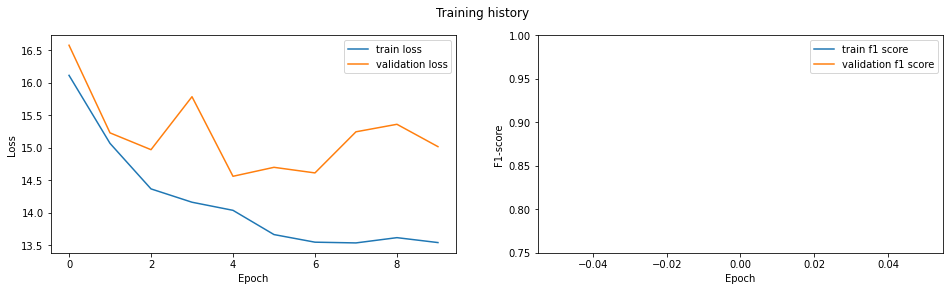

In [ ]:
import matplotlib.pyplot as plt
plot_history(history)

# Review Generate

In [9]:
configs.model_ckp_path = configs.path_drive / 'checkpoints' / 'koGPT_checkpoint_v2.pt'

tokenizer = TOKENIZER
model_eval = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2').to(configs.device)
model_eval.load_state_dict(torch.load(configs.model_ckp_path))

<All keys matched successfully>

In [10]:
def generate_reaction(model, tokenizer, review, star, configs):
  model.eval()
  tok = tokenizer
  with torch.no_grad():
    q = review
    sent = str(star)
    a = ''

    gen = ''
    cnt = 0
    while 1:
      gen_previous = gen
      input_ids = torch.LongTensor(tok.encode(U_TKN+q+SENT+sent+S_TKN+a)).to(configs.device)
      pred = model(input_ids).logits
      gen = tok.convert_ids_to_tokens(torch.argmax(pred, dim=-1).squeeze().cpu().numpy().tolist())[-1]

      if gen_previous == gen:
        cnt +=1
      else: cnt = 0

      if cnt > 20: gen = EOS
      if gen == EOS: break

      a += gen.replace('▁', ' ')
  
  return a


In [28]:
new_sentence = ['이 집 짱뽕 진짜 맛있네요',
                '음식이 다 식어서 왔어여,,, ㅠㅠ',
                '공짜로 줘도 다시는 안먹는다ㅎㅎㅎㅎㅎ',
                '공짜로 줘도 다시는 안먹는다.',
                'ㄷㄷㄷㄷ']
stars = [3,3,3,0,0]

for review, star in zip(new_sentence,stars):
  reaction = generate_reaction(model_eval, tokenizer, review, star, configs)
  print(reaction)

 안녕하세요 .^^ 저희 집 음식 맛있 게 드셔주셔서 감사 합니다.^^ ᄏ 앞으로 자주 불러주세요.^^ 혹시 드시는데 뭐 부족한 건 없으셨나요.?부족한 부분이 있으셨다면 다음 주문 시에 요청란이나 전화로 말씀 해 주시면 신경 바짝써서 반영 할게요. 언제든지 소통해 주시면 감사 하겠습니다.항상 건강 하시고 좋은 일들만 가득하셨으면 좋겠습니다. <unk> 리뷰 정말 감사 드립니다.
 고객님 ! 우선 주문 감사드리며 맛있 게 드셨다니 제가 고맙죠! 앞으로 도 기본에 충실함으로 보답드리겠습니다 항상 행복 하시길! (일관된 리뷰 죄송 합니다! 현재직원병가와늘어난 주문량으로인해 몇일간만 이렇게 답변드립니다 하지만 두분크게 뜨고 하나하나 읽고는 있답니다^^ ; 넓은마음으로 이해부탁드려요)
 주문해주셔서 감사 합니니다. 더욱 더 노력 해서 더욱 만족 드릴수 있는 매장 이 되도록 최선을 다 하겠습니다 . 리뷰 남겨주셔서 감사 합니다.
 주문해주셔서 감사 합니니다. 더욱 더 노력 해서 더욱 만족 드릴수 있는 매장 이 되도록 최선을 다 하겠습니다 . 리뷰 남겨주셔서 감사 합니다.
 주문해주셔서 감사 합니니다. 더욱 더 노력 해서 더욱 만족 드릴수 있는 매장 이 되도록 최선을 다 하겠습니다 . 리뷰 남겨주셔서 감사 합니다.
